# Styblinski-Tang

Consider the Styblinski-Tang function
 \begin{equation}
 \label{eq:model}
f(x)=\frac{1}{d} \sum_{i=1}^{d} (x_i^4 - 16 x_i^2 + 5x_i),
\end{equation}
where $x \in \mathfrak{X}=[-5,5]^d$.

The gradient of the Styblinski-Tang function is

\begin{equation}
\nabla f(x_i)= 4x_i^3 - 32x_i + 5.
\end{equation}



# Import libraries

In [43]:
import numpy as np 
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import textwrap

import metod_alg as mt
from metod_alg import metod_algorithm_functions as mt_alg
from metod_alg import objective_functions as mt_obj
import tqdm
import seaborn as sns
import SALib
from SALib.sample import sobol_sequence

# Contour Plot

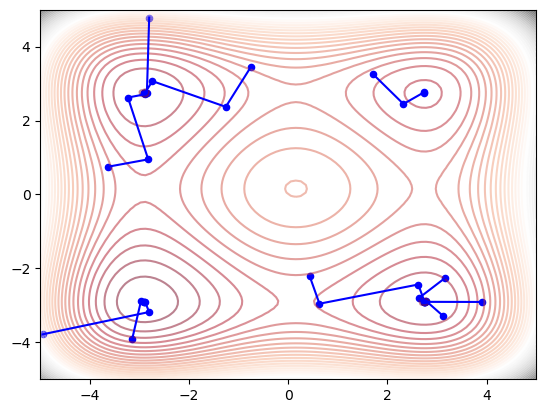

In [44]:
np.random.seed(100)
test_num = 100
bounds_p_1 = -5
bounds_p_2 = 5
num_p = 10
f = mt_obj.styblinski_tang_function
g = mt_obj.styblinski_tang_gradient
d = 2
args = (d, )
x = np.linspace(bounds_p_1, bounds_p_2, test_num)
y = np.linspace(bounds_p_1, bounds_p_2, test_num)
Z = np.zeros((test_num, test_num))
X, Y = np.meshgrid(x, y)
for i in range(test_num):
    for j in range(test_num):
        x1_var = X[i, j]
        x2_var = Y[i, j]
        Z[i, j] = f(np.array([x1_var, x2_var]).reshape(2, ), *args)

relax_sd_it = 1
usage = 'metod_algorithm'
tolerance=0.1
projection=False
option = 'forward_backward_tracking'
met = 'None'
initial_guess=0.005

for _ in range(num_p):
    x = np.random.uniform(bounds_p_1, bounds_p_2, (d,))
    descended_x_points, its = (mt_alg.apply_sd_until_stopping_criteria
                              (x, d, projection, tolerance, option,
                               met, initial_guess, args, f, g, 
                               bounds_p_1, bounds_p_2, usage, relax_sd_it))

    chosen_x1 = descended_x_points[0:descended_x_points.shape[0]][:,0]
    chosen_x2 = descended_x_points[0:descended_x_points.shape[0]][:,1]

    plt.scatter(chosen_x1, chosen_x2, s=20, color='blue')
    plt.plot(chosen_x1, chosen_x2, 'blue')

plt.contour(X, Y, Z, 50, cmap='RdGy', alpha=0.5)

# Results

For all results $d=5$, $N=500$ and $M=1$.

In [118]:
global_minimum = -39.16599 * d
d = 5
beta_list = [0.001, 0.01, 0.1]
m_list = [1]
avg_grad = np.zeros((len(m_list) * len(beta_list), 100, 500))

total_no_local_minimizers_metod = np.zeros((len(m_list), len(beta_list), 100))
time_taken_metod = np.zeros((len(m_list), len(beta_list), 100))
extra_descents_metod = np.zeros((len(m_list), len(beta_list), 100))
func_val_metod = np.zeros((len(m_list), len(beta_list), 100))

df_mult = pd.read_csv('stybl_tang_sd_metod_beta_0.1_m=1_d=5_random_500.csv')
total_no_local_minimizers_mult = np.array(df_mult['number_minimizers_per_func_multistart'])
time_taken_mult = np.array(df_mult['time_multistart'])
func_val_mult = np.array(df_mult['min_func_val_multistart'])
test = np.array(df_mult['number_minimizers_per_func_metod'])

index_all = 0
index_m = 0
for m in m_list:
    index_beta = 0
    for beta in beta_list:
        df_metod = pd.read_csv('stybl_tang_metod_beta_%s_m=%s_d=5_random_500.csv'% (beta, m))
        total_no_local_minimizers_metod[index_m, index_beta] = np.array(df_metod['number_minimizers_per_func_metod'])
        time_taken_metod[index_m, index_beta] = np.array(df_metod['time_metod'])
        func_val_metod[index_m, index_beta] = np.array(df_metod['min_func_val_metod'])
        if beta == 0.1 and m == 1:
            assert(np.all(total_no_local_minimizers_metod[index_m, index_beta] == test))
        extra_descents_metod[index_m, index_beta] = np.array(df_metod['number_extra_descents_per_func_metod'])

        avg_grad[index_all] = np.genfromtxt('stybl_tang_grad_norm_beta_%s_m=%s_d=5_random_500.csv'% (beta, m), delimiter=',')
        index_beta += 1
        index_all += 1
    index_m += 1

In [119]:
total_no_minimizers_prop = total_no_local_minimizers_metod / total_no_local_minimizers_mult

In [120]:
time_taken_prop = time_taken_metod / time_taken_mult

In [121]:
for j in range(len(beta_list) * len(m_list)):
    for k in range(j+1, len(beta_list) * len(m_list)):
            assert(np.all(np.round(avg_grad[k], 5) == np.round(avg_grad[j], 5)))

In [125]:
same_global_min = np.zeros((len(m_list), len(beta_list)))
same_minimizer = np.zeros((len(m_list), len(beta_list)))
mean_excessive_descents = np.zeros((len(m_list), len(beta_list)))
time_taken = np.zeros((len(m_list), len(beta_list)))
for i in range(len(m_list)):
    for j in range(len(beta_list)):
        assert(np.all(total_no_local_minimizers_mult >=  total_no_local_minimizers_metod[i, j]))
        same_global_min[i, j] = np.where(np.round(func_val_mult, 2) == np.round(func_val_metod[i, j], 2))[0].shape[0]
        same_minimizer[i, j] = np.sum(total_no_local_minimizers_metod[i, j]) / np.sum(total_no_local_minimizers_mult)
        time_taken[i, j] = np.sum(time_taken_metod[i, j]) / np.sum(time_taken_mult)

In [126]:
number_its = np.genfromtxt('stybl_tang_no_its_mult_beta_0.1_m=1_d=5_random_500.csv', delimiter=',')
store_mean_its = np.zeros((100))
store_min_its = np.zeros((100))
store_mean_norm_grad = np.zeros((100))
for j in range(100):
    store_mean_its[j] = np.mean(number_its[j])
    store_min_its[j] = np.min(number_its[j])
    store_mean_norm_grad[j] = 1 / np.mean(avg_grad[0][j])

In [127]:
import pandas as pd
function_info = pd.DataFrame({
                            "Average no of iterations local minimizer":
                            np.mean(store_mean_its),
                            "Average norm of grad at starting point":
                            np.mean(store_mean_norm_grad),
                            "Tolerance":
                            0.001,
                            "Global minimum":
                            global_minimum,
                            "No local minima": 32,
                            "No points": 500}, index=[0])
function_info

,Average no of iterations local minimizer,Average norm of grad at starting point,Tolerance,Global minimum,No local minima,No points
0,6.9006,0.009133,0.001,-195.82995,32,500


In [129]:
ticks = [beta_list[0],
          beta_list[1],
          beta_list[2]]
labels = [r'$M =$ %s' % (m_list[0])]

In [130]:
def set_box_color(bp, color):
    """Set colour for boxplot."""
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
def create_boxplots_ratio(arr1, labels, ticks):
    plt.figure(figsize=(7, 5))
    max_num = np.max(arr1)
    plt.ylim(0, max_num+0.1)
    bpl = plt.boxplot(arr1.T)
    set_box_color(bpl, 'green')
    plt.plot([], c='green', label=labels[0])
    plt.legend(bbox_to_anchor=(0.99, 1.025), loc='upper left',
               prop={'size': 15})
    plt.xlabel(r'$\beta$', size=14)
    plt.xticks(np.arange(1, len(ticks)+1), ticks, size=15)
    plt.yticks(fontsize=14)
    plt.tight_layout()

# Total number of local minima

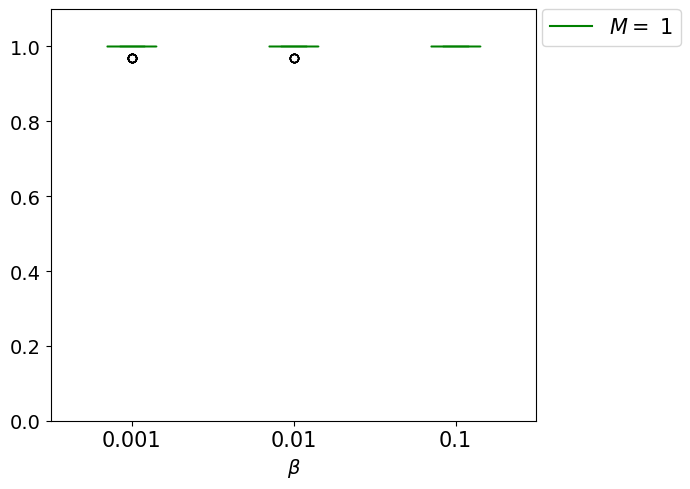

In [131]:
create_boxplots_ratio(total_no_minimizers_prop[0], labels, ticks)

# Efficiency

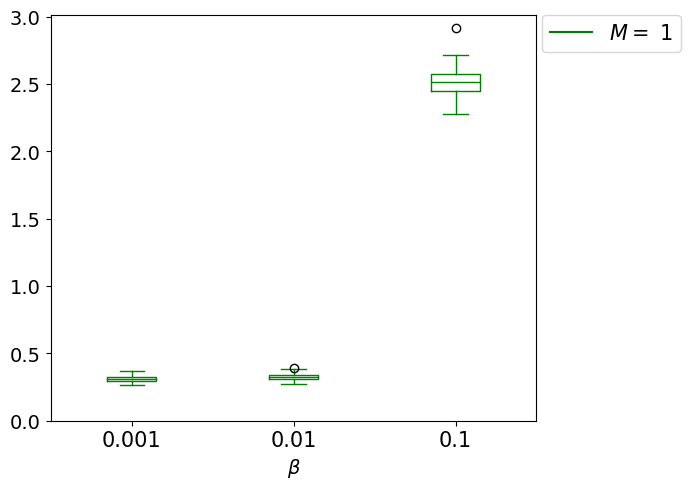

In [132]:
create_boxplots_ratio(time_taken_prop[0], labels, ticks)

# Excessive descents

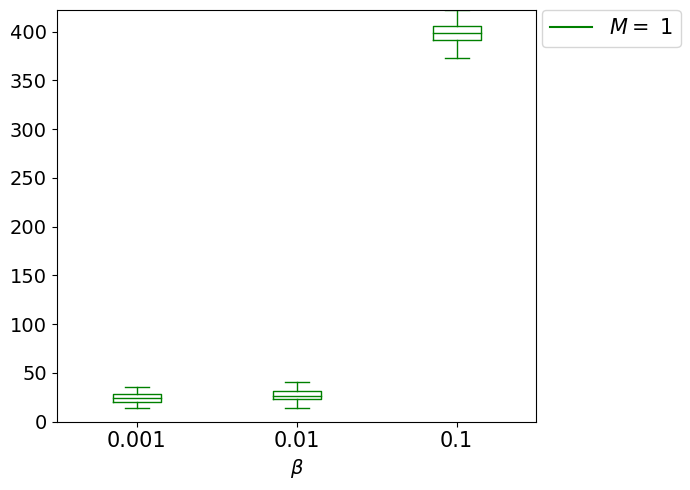

In [133]:
create_boxplots_ratio(extra_descents_metod[0], labels, ticks)